In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_squared_error

In [2]:

# Load your dataset
data = pd.read_csv("query_data.csv")
data

,Query,Batt,Dist,Wpts,Emot,Comf,Traf,Score,Relev
0,1,0.45,0.5000,0.3000,0.500,0.00,0.65,-0.571159,3.0
1,1,0.61,0.5000,0.1667,1.000,0.50,0.65,-1.107488,5.0
2,1,0.91,0.5556,0.5200,0.600,0.20,0.65,-0.276850,2.0
3,1,0.83,0.5000,0.4000,0.875,0.25,0.65,0.043321,1.0
4,1,0.46,0.5000,0.0500,1.000,0.50,0.65,-1.050039,4.0
...,...,...,...,...,...,...,...,...,...
499995,100000,0.41,0.5000,1.0000,0.750,0.50,0.93,1.569033,2.0
499996,100000,0.52,0.4000,0.2500,1.000,0.25,0.93,-0.069465,3.0
499997,100000,0.39,0.6667,0.0500,1.000,0.25,0.93,-0.464240,4.0
499998,100000,0.34,0.6667,0.7500,1.000,0.25,0.93,1.788080,1.0


In [3]:

# Extract features and target
X = data[["Batt", "Dist", "Wpts", "Emot", "Comf", "Traf"]]
y = data["Score"]
group = data.groupby("Query").size().to_list()  # Number of rows per query

In [4]:

# Get unique queries
unique_queries = data['Query'].unique()

# Split queries into train and test sets
train_queries, test_queries = train_test_split(unique_queries, test_size=0.2, random_state=42)

# Create training and testing data based on the query splits
train_mask = data['Query'].isin(train_queries)
test_mask = data['Query'].isin(test_queries)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# Compute groups for train and test sets
group_train = data[train_mask].groupby('Query').size().to_list()
group_test = data[test_mask].groupby('Query').size().to_list()

In [5]:
X_test[0:5]

,Batt,Dist,Wpts,Emot,Comf,Traf
40,0.87,0.50,0.625,1.0000,0.1250,0.58
41,0.43,0.75,0.200,0.8333,0.1667,0.58
42,0.41,0.50,0.500,0.7500,0.2500,0.58
43,0.25,0.50,0.500,1.0000,0.0000,0.58
44,0.25,0.50,0.500,0.5000,0.5000,0.58


In [6]:

# Prepare the training data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(group_train)  # Set group sizes for training

# Prepare the test data
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(group_test)  # Set group sizes for testing

In [7]:
params = {
    "objective": "reg:squarederror",  # Use regression objective for score prediction
    "learning_rate": 0.1,
    "max_depth": 8,
    "eval_metric": "rmse",  # Root Mean Squared Error for evaluation
    "tree_method": "auto",
}

In [8]:
evals_result = {}

# Train the model
rank_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "Test")],
    evals_result=evals_result,
    early_stopping_rounds=10
)

[0]	Test-rmse:1.09394
[1]	Test-rmse:0.99020
[2]	Test-rmse:0.89694
[3]	Test-rmse:0.81309
[4]	Test-rmse:0.73718
[5]	Test-rmse:0.66890
[6]	Test-rmse:0.60731
[7]	Test-rmse:0.55209
[8]	Test-rmse:0.50252
[9]	Test-rmse:0.45775
[10]	Test-rmse:0.41805
[11]	Test-rmse:0.38207
[12]	Test-rmse:0.34954
[13]	Test-rmse:0.32000
[14]	Test-rmse:0.29351
[15]	Test-rmse:0.26996
[16]	Test-rmse:0.24832
[17]	Test-rmse:0.22804
[18]	Test-rmse:0.21002
[19]	Test-rmse:0.19359
[20]	Test-rmse:0.17922
[21]	Test-rmse:0.16598
[22]	Test-rmse:0.15398
[23]	Test-rmse:0.14314
[24]	Test-rmse:0.13348
[25]	Test-rmse:0.12485
[26]	Test-rmse:0.11673
[27]	Test-rmse:0.10961
[28]	Test-rmse:0.10302
[29]	Test-rmse:0.09737
[30]	Test-rmse:0.09213
[31]	Test-rmse:0.08735
[32]	Test-rmse:0.08319
[33]	Test-rmse:0.07947
[34]	Test-rmse:0.07601
[35]	Test-rmse:0.07289
[36]	Test-rmse:0.07018
[37]	Test-rmse:0.06759
[38]	Test-rmse:0.06542
[39]	Test-rmse:0.06320
[40]	Test-rmse:0.06130
[41]	Test-rmse:0.05959
[42]	Test-rmse:0.05802
[43]	Test-rmse:0.0567

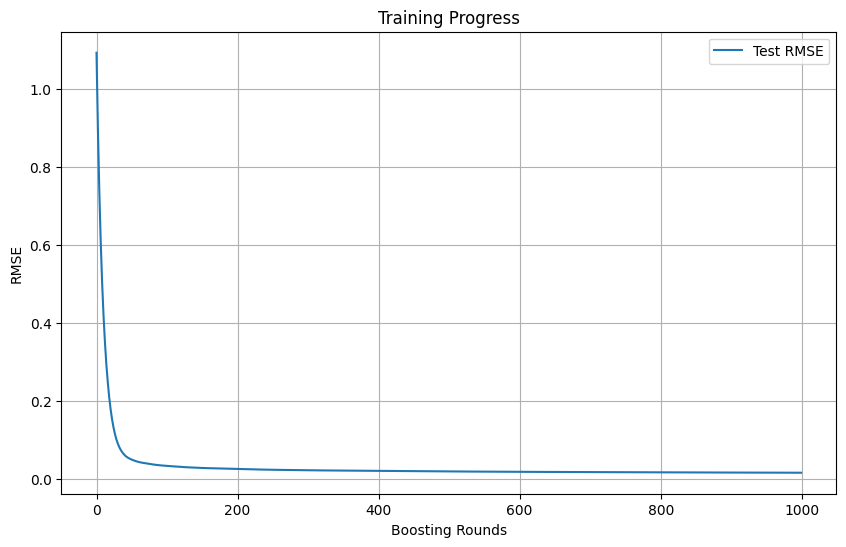

In [10]:

import matplotlib.pyplot as plt

# Retrieve metric data
test_metric = evals_result['Test']['rmse']  # Replace 'rmse' with your chosen metric

# Plot the metric
plt.figure(figsize=(10, 6))
plt.plot(test_metric, label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Predict scores
y_pred = rank_model.predict(dtest)
len(y_pred)

100000

In [12]:

# Assuming 5 items per query, rank them
query_results = y_pred[:5]  # Adjust as per group
ranked_positions = rankdata(-query_results, method="ordinal")  # Rank in descending order

print("Predicted Ranks:", ranked_positions)

Predicted Ranks: [4 5 2 1 3]


In [13]:
rank_model.save_model("xgboost_score_model.json")

In [14]:

# Load the test dataset (assuming it's a CSV file)
test_data = pd.read_csv('test_data.csv')

# Prepare the features and labels for evaluation
X_test = test_data.drop(columns=['Query','Score','Relev'])
y_test = test_data['Relev']  # The 'Relev' column is the true relevance score

In [15]:
# Convert the test data into DMatrix format
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
# Predict relevance scores for the test data
y_pred = rank_model.predict(dtest)

# Calculate NDCG (assuming relevance is given by 'y_test' and predicted relevance by 'y_pred')
ndcg_score_result = ndcg_score([y_test], [y_pred])
print(f'NDCG score: {ndcg_score_result}')

# Optionally, you can compute Mean Squared Error (MSE) as a baseline evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

NDCG score: 0.91847027180378
Mean Squared Error: 16.081298942681418


In [17]:
actual_rank = y_test[:5]
print(actual_rank)


0    2.0
1    4.0
2    5.0
3    3.0
4    1.0
Name: Relev, dtype: float64


In [18]:
actual_rank = rankdata(y_test[:5], method="ordinal")
print(actual_rank)

[2 4 5 3 1]


In [21]:

# # Assuming y_pred and y_test are your predicted and true relevance values
# # Get the number of query groups
# num_groups = len(y_pred) // 5  # Total number of 5-item query groups

# # Loop through the groups and print the predicted ranks vs true ranks
# for i in range(num_groups):
#     start = i * 5
#     end = (i + 1) * 5
    
#     # Get predicted scores for the current query group
#     query_results = y_pred[start:end]  # Adjust as per group
#     ranked_positions = rankdata(query_results, method="ordinal")  # Rank in descending order
    
#     # Get true relevance scores for the current query group
#     actual_relevance = y_test[start:end]
#     actual_rank = rankdata(actual_relevance, method="ordinal")
    
#     print(f"Group {i + 1}:")
#     print("Predicted Ranks:", ranked_positions)
#     print("True Ranks:", actual_rank)
#     print()


In [21]:
group_num = 7

start = (group_num-1) * 5
end   = group_num * 5

# Get predicted scores for the current query group
query_results = y_pred[start:end]  # Adjust as per group
ranked_positions = rankdata(-query_results, method="ordinal")  # Rank in descending order

# Get true relevance scores for the current query group
actual_relevance = y_test[start:end]
actual_rank = rankdata(actual_relevance, method="ordinal")

print(f"Group {group_num}:")
print("Predicted Ranks:", ranked_positions)
print("True Ranks:", actual_rank)
print()

Group 7:
Predicted Ranks: [5 2 4 3 1]
True Ranks: [5 2 4 3 1]



In [20]:

# Get the number of query groups
num_groups = len(y_pred) // 5  # Total number of 5-item query groups

correct_count = 0  # Counter to track correct rankings
total_count = 0  # Total number of groups

# Loop through the groups and compare the predicted ranks vs true ranks
for i in range(num_groups):
    start = i * 5
    end = (i + 1) * 5
    
    # Get predicted scores for the current query group
    query_results = y_pred[start:end]  # Adjust as per group
    ranked_positions = rankdata(-query_results, method="ordinal")  # Rank in descending order
    
    # Get true relevance scores for the current query group
    actual_relevance = y_test[start:end]
    actual_rank = rankdata(actual_relevance, method="ordinal")
    
    # Compare predicted and actual ranks
    if (ranked_positions == actual_rank).all():  # Check if ranks are exactly the same
        correct_count += 1
    
    total_count += 1

# Calculate overall accuracy
accuracy = correct_count / total_count
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9603
